### In this notebook I use dask

This is demonstrating how to use dask for our data processing. 

In [1]:
import dask

### Load the data

In [19]:
from data_processing import load_data, get_files, parse_filename, drop_nd_rows
from feature_extraction import extract_fft_features, extract_time_domain_features
from transformations import interpolate_zeros, replace_outliers_with_zeros
import pandas as pd
import dask
from dask import do
from os.path import split
from dask import delayed, compute

In [4]:
files =get_files()[:2]

```python

def parse_filename(filename, split_file=False):
    """Parses m filename to get the pertinent information"""
    if split_file:
        filename = split(filename)[1]

    # strip out the .mat
    filename = filename.replace('.mat', '')

    # parse the remaing part
    return [int(part) for part in filename.split('_')]

def map_functions(data, functions):
    """maps a list of functions to data and returns as a list of results
    Parameters: 
        data: data to be computed on
        functions(list): a list of functions
    Returns: 
        results(list): a list of the results
    """
    return [fun(data) for fun in functions]


def process_data(file_name, functions=None):
    """Processes one file at a time for extracting features
    Parameters: 
        file_name(str): the file name
        functions(list): a list of functions for extracting features
    Returns: 
        res(pd.DataFrame): a one row data frame with the features in the columns    
    """
    
    if functions is None: 
        functions = [extract_time_domain_features,extract_fft_features]
    
    # get the time series and parse the filename for the info
    time_series = load_data(file_name,True)[0]
    patient,number,condition = parse_filename(file_name, True)
    
    # create an index and prefix df
    index = pd.MultiIndex.from_tuples([(patient, number, condition)], 
                                      names=['Patient', 'TraceNumber', 'Condition'])

    prefix_df = pd.DataFrame({'Patient':patient,
                              'TraceNumber':number,
                              'Condition':condition},
                             index = [0]
                              )
    
    # create a list two hold the data frames, call the functions and then concatenate the resulting dataframes
    res = [prefix_df]
    res.extend(map_functions(time_series,functions))
    res = pd.concat(res, axis =1)
    res.index = index
    return res
    
def process_multiple_data(files):
    """uses dask to process many files in parallel"""
    # set up the compute graph
    graph = delayed([delayed(process_data)(file_) for file_ in files])
    # compute the graph
    results = compute(graph)
    
    return pd.concat([results[0][i] for i in range(len(files))]) ```

features = process_multiple_data(files)

In [ ]:
def map_functions(data, functions):
    """maps a list of functions to data (slowly)"""
    return [fun(data) for fun in functions]

import numpy as np
functions = [np.sin, np.cos]
map_functions(1,functions)

### Try the new code


In [1]:
from os import listdir
import pandas as pd
from os.path import join, split
from data_processing import Processor,get_data_files,load_data,interpolate_zeros,replace_outliers_with_zeros

In [2]:
processor = Processor()

In [3]:
paths =['/Users/crivera5/Documents/NonIntuitProjects/Kaggle/KaggleEEG/train_1',
       '/Users/crivera5/Documents/NonIntuitProjects/Kaggle/KaggleEEG/train_2',
       '/Users/crivera5/Documents/NonIntuitProjects/Kaggle/KaggleEEG/train_3']

In [ ]:
res = processor.process_data(paths)

In [ ]:
from feature_extraction import extract_time_domain_features

In [ ]:
base = test_path[0]
data=load_data(join(base,listdir(base)[0]))[0]
listdir(base)

In [ ]:
import numpy as np
def interpolate_zeros(df):
    """Replaces zero values using linear interpolation
    Parameters:
        df(pd.DataFrame): a data frame with numeric values
    Returns:
        df
    """

    def replace_zeros(x):
        if x == 0:
            return np.nan
        return x

    df = df.copy()
    df = df.applymap(replace_zeros)
    return df.interpolate(method='linear')


In [ ]:
res = interpolate_zeros(data)

In [ ]:
s = extract_time_domain_features(res)

In [ ]:
s

In [ ]:
?s.empty

In [ ]:
s.isnull().sum().sum()==0

In [ ]:
res

In [6]:
files = get_files()

In [14]:
data = load_data(files[4])[0]

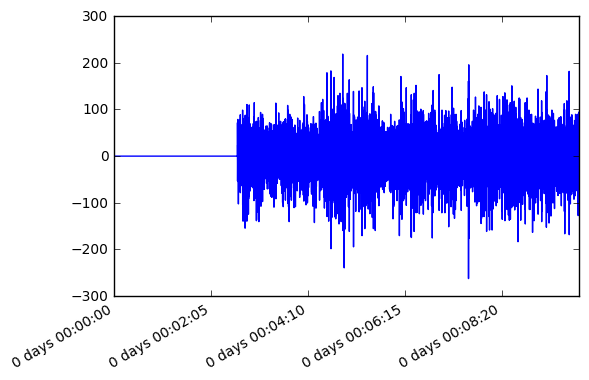

In [15]:
%matplotlib inline 
data[1.0].plot()

In [40]:
def drop_nd_rows(df):
    """ Drop rows that have all 0 across all columns

    :param df: Data Dataframe to calculate
    :return: df: Data Dataframe with dropped row.
    """
    return df.loc[df.sum(axis=1) != 0].copy()



In [41]:
data = load_data(files[4])[0]
transform1 = drop_nd_rows(data)
transform1

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0
00:02:39.195000,68.641670,47.857742,-11.506486,-22.262894,84.294441,100.811531,46.177467,10.791378,46.664951,62.791901,-144.183868,146.825119,-91.002174,0.791873,-163.073532,-176.946121
00:02:39.197500,68.641670,43.857742,-16.506487,-19.262894,87.294441,102.811531,49.177467,10.791378,46.664951,58.791901,-140.183868,138.825119,-88.002174,-2.208127,-161.073532,-176.946121
00:02:39.200000,71.641670,38.857742,-21.506487,-18.262894,91.294441,107.811531,47.177467,10.791378,39.664951,52.791901,-137.183868,134.825119,-86.002174,-2.208127,-155.073532,-172.946121
00:02:39.202500,68.641670,34.857742,-19.506487,-15.262895,93.294441,115.811531,47.177467,16.791378,34.664951,43.791901,-136.183868,136.825119,-83.002174,-6.208127,-156.073532,-169.946121
00:02:39.205000,64.641670,31.857742,-19.506487,-13.262895,91.294441,116.811531,49.177467,21.791378,30.664953,44.791901,-138.183868,136.825119,-84.002174,-7.208127,-157.073532,-165.946121
00:02:39.207500,56.641670,27.857742,-17.506487,-9.262895,97.294441,119.811531,44.177467,26.791378,21.664953,47.791901,-138.183868,136.825119,-87.002174,-13.208127,-153.073532,-159.946121
00:02:39.210000,51.641670,19.857742,-11.506486,-4.262894,100.294441,118.811531,44.177467,23.791378,17.664953,49.791901,-137.183868,136.825119,-85.002174,-17.208126,-155.073532,-153.946121
00:02:39.212500,41.641670,21.857742,-7.506486,-7.262894,102.294441,120.811531,46.177467,25.791378,16.664953,49.791901,-137.183868,134.825119,-82.002174,-19.208126,-153.073532,-150.946121
00:02:39.215000,40.641670,19.857742,-5.506486,-6.262894,98.294441,117.811531,47.177467,23.791378,16.664953,50.791901,-136.183868,132.825119,-79.002174,-20.208126,-154.073532,-145.946121
00:02:39.217500,34.641670,18.857742,-9.506486,-6.262894,100.294441,119.811531,43.177467,22.791378,13.664953,52.791901,-140.183868,136.825119,-76.002174,-18.208126,-150.073532,-139.946121


In [42]:
transform2= replace_outliers_with_zeros(transform1)

In [43]:
transform3 = interpolate_zeros(transform2)

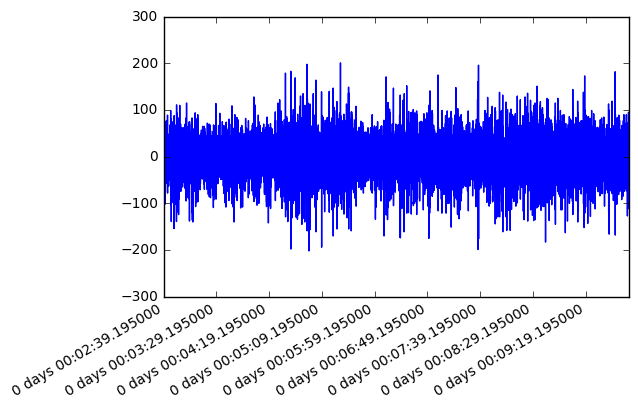

In [45]:
transform3[1.0].plot()

In [63]:
test = data.tail(10).copy()

In [73]:
import numpy as np
test.iloc[[0,1,2,3],[1,2,3]]=np.nan
test

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0
00:09:59.975000,-74.35833,NaN,NaN,NaN,-8.705559,37.811535,-46.822533,57.791378,-84.335045,-8.208098,149.816132,-105.174873,-227.002182,-155.20813,305.926483,172.053879
00:09:59.977500,-87.35833,NaN,NaN,NaN,-20.705559,32.811535,-19.822533,66.791382,-90.335045,-20.208099,140.816132,-104.174873,-204.002182,-164.20813,317.926483,173.053879
00:09:59.980000,-96.35833,NaN,NaN,NaN,-28.705559,24.811533,8.177467,74.791382,-99.335045,-34.208099,132.816132,-107.174873,-169.002182,-153.20813,322.926483,171.053879
00:09:59.982500,-98.35833,NaN,NaN,NaN,-35.705559,16.811533,35.177467,81.791382,-111.335045,-50.208099,117.816132,-109.174873,-123.002174,-145.20813,319.926483,169.053879
00:09:59.985000,-100.35833,-75.142258,-23.506487,1.737106,-44.705559,11.811534,55.177467,90.791382,-123.335045,-64.208099,106.816132,-111.174873,-70.002174,-155.20813,326.926483,173.053879
00:09:59.987500,-98.35833,-89.142258,-30.506487,6.737106,-47.705559,2.811533,77.177467,97.791382,-125.335045,-79.208099,95.816132,-117.174873,-34.002178,-158.20813,329.926483,166.053879
00:09:59.990000,-100.35833,-94.142258,-35.506485,-2.262894,-56.705559,-5.188467,100.177467,108.791382,-127.335045,-90.208099,86.816132,-122.174873,-3.002178,-131.20813,322.926483,160.053879
00:09:59.992500,-103.35833,-96.142258,-41.506485,-16.262894,-64.705559,-11.188466,114.177467,116.791382,-129.335052,-98.208099,83.816132,-127.174873,20.997822,-114.20813,309.926483,155.053879
00:09:59.995000,-105.35833,-91.142258,-46.506485,-30.262894,-64.705559,-15.188466,119.177467,115.791382,-135.335052,-102.208099,83.816132,-128.174881,42.997822,-109.20813,310.926483,152.053879
00:09:59.997500,-111.35833,-99.142258,-51.506485,-41.262894,-66.705559,-16.188467,131.177475,109.791382,-135.335052,-102.208099,84.816132,-127.174873,62.997822,-99.20813,319.926483,148.053879


In [76]:
test.fillna(method = 'ffill',inplace = True)
test.fillna(method = 'bfill',inplace = True)

In [77]:
test

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0
00:09:59.975000,-74.35833,-75.142258,-23.506487,1.737106,-8.705559,37.811535,-46.822533,57.791378,-84.335045,-8.208098,149.816132,-105.174873,-227.002182,-155.20813,305.926483,172.053879
00:09:59.977500,-87.35833,-75.142258,-23.506487,1.737106,-20.705559,32.811535,-19.822533,66.791382,-90.335045,-20.208099,140.816132,-104.174873,-204.002182,-164.20813,317.926483,173.053879
00:09:59.980000,-96.35833,-75.142258,-23.506487,1.737106,-28.705559,24.811533,8.177467,74.791382,-99.335045,-34.208099,132.816132,-107.174873,-169.002182,-153.20813,322.926483,171.053879
00:09:59.982500,-98.35833,-75.142258,-23.506487,1.737106,-35.705559,16.811533,35.177467,81.791382,-111.335045,-50.208099,117.816132,-109.174873,-123.002174,-145.20813,319.926483,169.053879
00:09:59.985000,-100.35833,-75.142258,-23.506487,1.737106,-44.705559,11.811534,55.177467,90.791382,-123.335045,-64.208099,106.816132,-111.174873,-70.002174,-155.20813,326.926483,173.053879
00:09:59.987500,-98.35833,-89.142258,-30.506487,6.737106,-47.705559,2.811533,77.177467,97.791382,-125.335045,-79.208099,95.816132,-117.174873,-34.002178,-158.20813,329.926483,166.053879
00:09:59.990000,-100.35833,-94.142258,-35.506485,-2.262894,-56.705559,-5.188467,100.177467,108.791382,-127.335045,-90.208099,86.816132,-122.174873,-3.002178,-131.20813,322.926483,160.053879
00:09:59.992500,-103.35833,-96.142258,-41.506485,-16.262894,-64.705559,-11.188466,114.177467,116.791382,-129.335052,-98.208099,83.816132,-127.174873,20.997822,-114.20813,309.926483,155.053879
00:09:59.995000,-105.35833,-91.142258,-46.506485,-30.262894,-64.705559,-15.188466,119.177467,115.791382,-135.335052,-102.208099,83.816132,-128.174881,42.997822,-109.20813,310.926483,152.053879
00:09:59.997500,-111.35833,-99.142258,-51.506485,-41.262894,-66.705559,-16.188467,131.177475,109.791382,-135.335052,-102.208099,84.816132,-127.174873,62.997822,-99.20813,319.926483,148.053879
